Mestrado em Modelagem Matematica da Informacao
----------------------------------------------
Disciplina: Modelagem e Mineracao de Dados
------------------------------------------

Master Program - Mathematical Modeling of Information
-----------------------------------------------------
Course: Data Mining and Modeling
--------------------------------

Professor: Renato Rocha Souza
-----------------------------

### Topic: Clustering documents

This notebook is based on http://www.brandonrose.org and http://www.brandonrose.org/top100  

In this guide, I will explain how to cluster a set of documents using Python. My motivating example is to identify the latent structures within the synopses of the top 100 films of all time (per an IMDB list). 

This notebook covers:

<ul>
<li> tokenizing and stemming each synopsis
<li> transforming the corpus into vector space using [tf-idf](http://en.wikipedia.org/wiki/Tf%E2%80%93idf)
<li> calculating cosine distance between each document as a measure of similarity
<li> clustering the documents using the [k-means algorithm](http://en.wikipedia.org/wiki/K-means_clustering)
<li> using [multidimensional scaling](http://en.wikipedia.org/wiki/Multidimensional_scaling) to reduce dimensionality within the corpus
<li> plotting the clustering output using [matplotlib](http://matplotlib.org/) and [mpld3](http://mpld3.github.io/)
<li> conducting a hierarchical clustering on the corpus using [Ward clustering](http://en.wikipedia.org/wiki/Ward%27s_method)
<li> plotting a Ward dendrogram
<li> topic modeling using [Latent Dirichlet Allocation (LDA)](http://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)
</ul>

## Contents

<ul>
<li>[Stopwords, stemming, and tokenization](#Stopwords,-stemming,-and-tokenizing)
<li>[Tf-idf and document similarity](#Tf-idf-and-document-similarity)
<li>[K-means clustering](#K-means-clustering)
<li>[Multidimensional scaling](#Multidimensional-scaling)
<li>[Visualizing document clusters](#Visualizing-document-clusters)
<li>[Hierarchical document clustering](#Hierarchical-document-clustering)
<li>[Latent Dirichlet Allocation (LDA)](#Latent-Dirichlet-Allocation)
</ul>

But first, I import everything I am going to need up front

In [46]:
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
import pyLDAvis
import pyLDAvis.gensim

/home/rsouza/python/3/venv/local/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/home/rsouza/python/3/venv/local/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/home/rsouza/python/3/venv/local/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/home/rsouza/python/3/venv/local/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/home/rsouza/python/3/venv/local/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead

Specifying the path to the files  

In [116]:
datapath = "../datasets/"
outputs = "../outputs/"

# Stopwords, stemming, and tokenizing

In [47]:
#import three lists: titles, links and wikipedia synopses
titles = open('title_list.txt').read().split('\n')
#ensures that only the first 100 are read in
titles = titles[:100]

links = open('link_list_imdb.txt').read().split('\n')
links = links[:100]

synopses_wiki = open('synopses_list_wiki.txt').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_clean_wiki = []
for text in synopses_wiki:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_wiki.append(text)

synopses_wiki = synopses_clean_wiki
    
    
genres = open('genres_list.txt').read().split('\n')
genres = genres[:100]

print(str(len(titles)) + ' titles')
print(str(len(links)) + ' links')
print(str(len(synopses_wiki)) + ' synopses')
print(str(len(genres)) + ' genres')

100 titles
100 links
100 synopses
100 genres


In [48]:
synopses_imdb = open('synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

synopses_clean_imdb = []

for text in synopses_imdb:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_imdb.append(text)

synopses_imdb = synopses_clean_imdb

In [49]:
synopses = []

for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)

In [50]:
# generates index for each item in the corpora (in this case it's just rank) and I'll use this for scoring later
ranks = []

for i in range(0,len(titles)):
    ranks.append(i)

This section is focused on defining some functions to manipulate the synopses. First, I load [NLTK's](http://www.nltk.org/) list of English stop words. [Stop words](http://en.wikipedia.org/wiki/Stop_words) are words like "a", "the", or "in" which don't convey significant meaning. I'm sure there are much better explanations of this out there.

In [51]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

Next I import the [Snowball Stemmer](http://snowball.tartarus.org/) which is actually part of NLTK. [Stemming](http://en.wikipedia.org/wiki/Stemming) is just the process of breaking a word down into its root.

In [52]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")


Below I define two functions:

<ul>
<li> *tokenize_and_stem*: tokenizes (splits the synopsis into a list of its respective words (or tokens) and also stems each token <li> *tokenize_only*: tokenizes the synopsis only
</ul>

I use both these functions to create a dictionary which becomes important in case I want to use stems for an algorithm, but later convert stems back to their full words for presentation purposes. Guess what, I do want to do that!



In [53]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

Below I use my stemming/tokenizing and tokenizing functions to iterate over the list of synopses to create two vocabularies: one stemmed and one only tokenized. 

In [54]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

Using these two lists, I create a pandas DataFrame with the stemmed vocabulary as the index and the tokenized words as the column. The benefit of this is it provides an efficient way to look up a stem and return a full token. The downside here is that stems to tokens are one to many: the stem 'run' could be associated with 'ran', 'runs', 'running', etc. For my purposes this is fine--I'm perfectly happy returning the first token associated with the stem I need to look up.

In [55]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

## Tf-idf and document similarity

<img src='http://www.jiem.org/index.php/jiem/article/viewFile/293/252/2402' align='right' style="margin-left:10px">

Here, I define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the *synopses* list into a tf-idf matrix. 

To get a Tf-idf matrix, first count word occurrences by document. This is transformed into a document-term matrix (dtm). This is also just called a term frequency matrix. An example of a dtm is here at right.

Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document.

A couple things to note about the parameters I define below:

<ul>
<li> max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopses)
<li> min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document. I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.
<li> ngram_range: this just means I'll look at unigrams, bigrams and trigrams. See [n-grams](http://en.wikipedia.org/wiki/N-gram)
</ul>

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, 
                                   max_features=200000,
                                   min_df=0.2, 
                                   stop_words='english',
                                   use_idf=True, 
                                   tokenizer=tokenize_and_stem, 
                                   ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

print(tfidf_matrix.shape)

CPU times: user 10.6 s, sys: 32 ms, total: 10.6 s
Wall time: 10.6 s
(100, 563)


In [57]:
terms = tfidf_vectorizer.get_feature_names()

In [58]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

# K-means clustering

Now onto the fun part. Using the tf-idf matrix, you can run a slew of clustering algorithms to better understand the hidden structure within the synopses. I first chose [k-means](http://en.wikipedia.org/wiki/K-means_clustering). K-means initializes with a pre-determined number of clusters (I chose 5). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and  centroids recalculated in an iterative process until the algorithm reaches convergence.

I found it took several runs for the algorithm to converge a global optimum as k-means is susceptible to reaching local optima. 

In [59]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 152 ms, sys: 0 ns, total: 152 ms
Wall time: 151 ms


In [60]:
from sklearn.externals import joblib

#joblib.dump(km,  'doc_cluster.pkl')
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [61]:
import pandas as pd

films = {'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters, 'genre': genres}

frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])

In [62]:
frame['cluster'].value_counts()

4    26
0    25
2    21
1    16
3    12
Name: cluster, dtype: int64

In [63]:
grouped = frame['rank'].groupby(frame['cluster'])

grouped.mean()

cluster
0    47.200000
1    58.875000
2    49.380952
3    54.500000
4    43.730769
Name: rank, dtype: float64

In [64]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    print()
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words: b'family', b'home', b'mother', b'war', b'house', b'dies',

Cluster 0 titles: Schindler's List, One Flew Over the Cuckoo's Nest, Gone with the Wind, The Wizard of Oz, Titanic, Forrest Gump, E.T. the Extra-Terrestrial, The Silence of the Lambs, Gandhi, A Streetcar Named Desire, The Best Years of Our Lives, My Fair Lady, Ben-Hur, Doctor Zhivago, The Pianist, The Exorcist, Out of Africa, Good Will Hunting, Terms of Endearment, Giant, The Grapes of Wrath, Close Encounters of the Third Kind, The Graduate, Stagecoach, Wuthering Heights,

Cluster 1 words: b'police', b'car', b'killed', b'murders', b'driving', b'house',

Cluster 1 titles: Casablanca, Psycho, Sunset Blvd., Vertigo, Chinatown, Amadeus, High Noon, The French Connection, Fargo, Pulp Fiction, The Maltese Falcon, A Clockwork Orange, Double Indemnity, Rebel Without a Cause, The Third Man, North by Northwest,

Cluster 2 words: b'father', b'new', b'york', b'new', b'brothers', b'apartments',

Clust

In [65]:
#This is purely to help export tables to html and to correct for my 0 start rank (so that Godfather is 1, not 0)
frame['Rank'] = frame['rank'] + 1
frame['Title'] = frame['title']

In [66]:
#export tables to HTML
print(frame[['Rank', 'Title']].loc[frame['cluster'] == 1].to_html(index=False))

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Rank</th>
      <th>Title</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>5</td>
      <td>Casablanca</td>
    </tr>
    <tr>
      <td>13</td>
      <td>Psycho</td>
    </tr>
    <tr>
      <td>14</td>
      <td>Sunset Blvd.</td>
    </tr>
    <tr>
      <td>15</td>
      <td>Vertigo</td>
    </tr>
    <tr>
      <td>24</td>
      <td>Chinatown</td>
    </tr>
    <tr>
      <td>31</td>
      <td>Amadeus</td>
    </tr>
    <tr>
      <td>57</td>
      <td>High Noon</td>
    </tr>
    <tr>
      <td>64</td>
      <td>The French Connection</td>
    </tr>
    <tr>
      <td>77</td>
      <td>Fargo</td>
    </tr>
    <tr>
      <td>87</td>
      <td>Pulp Fiction</td>
    </tr>
    <tr>
      <td>91</td>
      <td>The Maltese Falcon</td>
    </tr>
    <tr>
      <td>92</td>
      <td>A Clockwork Orange</td>
    </tr>
    <tr>
      <td>95</td>
      <td>Double Indemnity</td>
    </tr>
    <tr

# Multidimensional scaling

In [67]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [68]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

## Visualizing document clusters

In [69]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}

In [70]:
%matplotlib inline

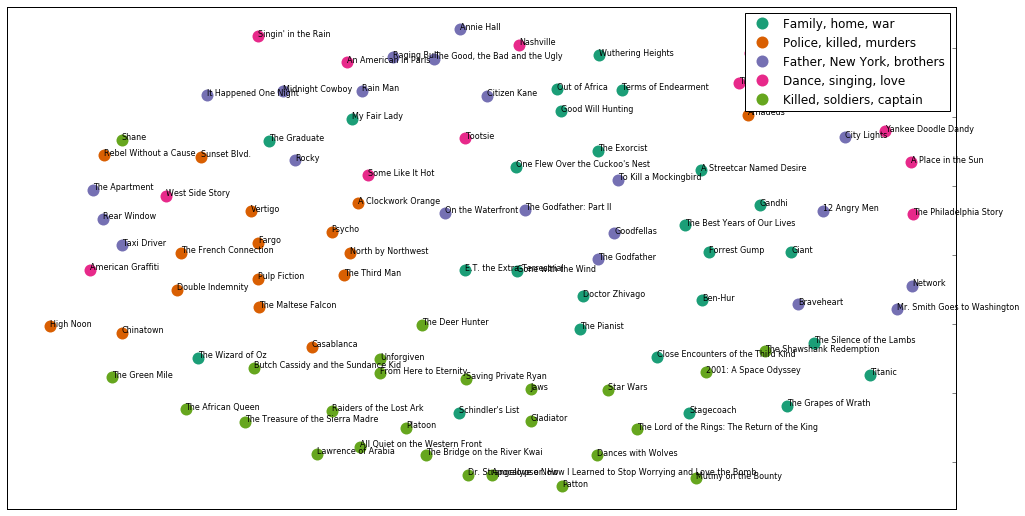

In [71]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [72]:
plt.close()

The clustering plot looks great, but it pains my eyes to see overlapping labels. Having some experience with [D3.js](http://d3js.org/) I knew one solution would be to use a browser based/javascript interactive. Fortunately, I recently stumbled upon [mpld3](https://mpld3.github.io/) a matplotlib wrapper for D3. Mpld3 basically let's you use matplotlib syntax to create web interactives. It has a really easy, high-level API for adding tooltips on mouse hover, which is what I am interested in.

It also has some nice functionality for zooming and panning. The below javascript snippet basicaly defines a custom location for where the zoom/pan toggle resides. Don't worry about it too much and you actually don't need to use it, but it helped for formatting purposes when exporting to the web later. The only thing you might want to change is the x and y attr for the position of the toolbar.

In [73]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [74]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, label=cluster_names[name], mec='none', color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

# Hierarchical document clustering

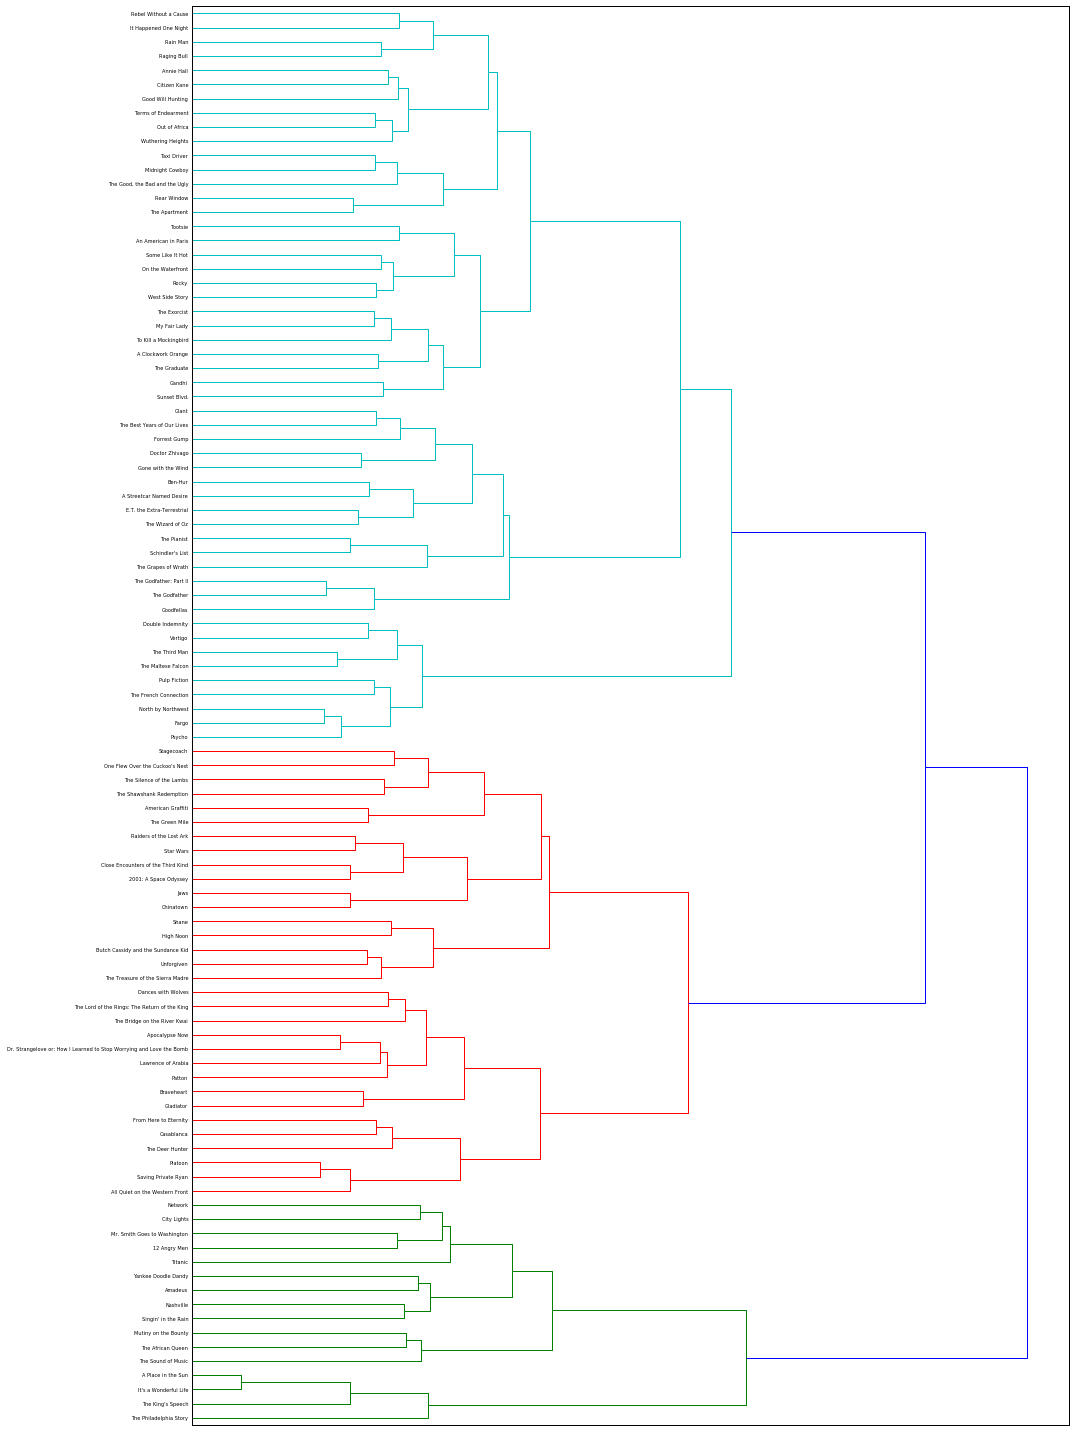

In [75]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [76]:
plt.close()

# Latent Dirichlet Allocation

In [77]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [78]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [79]:
#Latent Dirichlet Allocation implementation with Gensim

from gensim import corpora, models, similarities 

#remove proper names
preprocess = [strip_proppers(doc) for doc in synopses]

%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

CPU times: user 4.75 s, sys: 0 ns, total: 4.75 s
Wall time: 4.75 s
CPU times: user 408 ms, sys: 4 ms, total: 412 ms
Wall time: 412 ms


In [80]:
#print(len([word for word in texts[0] if word not in stopwords]))
print(len(texts[0]))

1839


In [81]:
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=1, no_above=0.8)
corpus = [dictionary.doc2bow(text) for text in texts]

In [82]:
len(corpus)

100

In [83]:
%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

CPU times: user 5min 10s, sys: 276 ms, total: 5min 11s
Wall time: 5min 10s


In [84]:
print(lda[corpus[0]])

[(0, 0.99950490726250485)]


In [85]:
topics = lda.print_topics(5, num_words=20)

In [112]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)

In [114]:
topics_matrix[0]

(0,
 [('kill', 0.0064006750095094876),
  ('famili', 0.0060504577850370818),
  ('meet', 0.0051520378977228127),
  ('ask', 0.0047850213990042832),
  ('say', 0.0043721636790960096),
  ('father', 0.0043324617235229144),
  ('home', 0.0042102521789343953),
  ('day', 0.0038408242789281476),
  ('friend', 0.0035118225958194831),
  ('help', 0.0034007757687734602),
  ('go', 0.0033026304537734827),
  ('arriv', 0.0032442129002973517),
  ('night', 0.0031421487250824116),
  ('two', 0.003112005113858317),
  ('car', 0.0030835344849231136),
  ('also', 0.0029869013788837904),
  ('name', 0.00296672177453732),
  ('die', 0.0029530148473153922),
  ('death', 0.0029058280494345884),
  ('way', 0.0029020122971938336)])

In [115]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      25.358835        1       1  0.002639 -0.025267
1      21.025879        1       2 -0.088431  0.061752
2      18.620918        1       3 -0.040557 -0.070280
3      17.797962        1       4  0.053796 -0.012008
4      17.196407        1       5  0.072553  0.045803, topic_info=     Category        Freq     Term       Total  loglift  logprob
term                                                            
1728  Default  111.000000    shark  111.000000  30.0000  30.0000
3396  Default  114.000000     boat  114.000000  29.0000  29.0000
6426  Default  104.000000     sing  104.000000  28.0000  28.0000
1757  Default  143.000000    water  143.000000  27.0000  27.0000
2526  Default  201.000000  soldier  201.000000  26.0000  26.0000
3061  Default  205.000000    apart  205.000000  25.0000  25.0000
6072  Default   62.000000    bridg   62.000000  24.0000  24.0000
721   Default   81.000000   villag   81.000000  23.0000  23.0000
6974  Default   64.000000  mission   64.000000  22.0000  22.0000
6375  Default  344.000000   famili  344.000000  21.0000  21.0000
7984  Default   90.000000  perform   90.000000  20.0000  20.0000
224   Default   46.000000    alien   46.000000  19.0000  19.0000
8027  Default  100.000000   window  100.000000  18.0000  18.0000
2279  Default   53.000000   guilti   53.000000  17.0000  17.0000
6172  Default  134.000000     ship  134.000000  16.0000  16.0000
1366  Default   56.000000     vote   56.000000  15.0000  15.0000
7058  Default  260.000000    fight  260.000000  14.0000  14.0000
3519  Default   39.000000     king   39.000000  13.0000  13.0000
2066  Default   55.000000    river   55.000000  12.0000  12.0000
5769  Default   29.000000    juror   29.000000  11.0000  11.0000
7937  Default   48.000000    beach   48.000000  10.0000  10.0000
2244  Default   39.000000    squad   39.000000   9.0000   9.0000
5343  Default  150.000000      war  150.000000   8.0000   8.0000
6642  Default  596.000000     kill  596.000000   7.0000   7.0000
3437  Default  225.000000   murder  225.000000   6.0000   6.0000
1405  Default   48.000000     song   48.000000   5.0000   5.0000
173   Default   27.000000    droid   27.000000   4.0000   4.0000
5674  Default  124.000000      job  124.000000   3.0000   3.0000
1544  Default   30.000000    ranch   30.000000   2.0000   2.0000
1297  Default   35.000000      pod   35.000000   1.0000   1.0000
...       ...         ...      ...         ...      ...      ...
919    Topic5   85.487431     call  334.436011   0.3964  -5.4620
2292   Topic5   27.615162   servic   54.071372   1.0885  -6.5920
3194   Topic5   63.712700    drive  209.260039   0.5713  -5.7560
5514   Topic5   90.795436      n't  377.801858   0.3347  -5.4018
1131   Topic5   41.778246   hospit  106.599989   0.8238  -6.1780
2268   Topic5   53.040350   appear  161.825977   0.6450  -5.9393
6431   Topic5   58.548473     look  208.065971   0.4925  -5.8405
2685   Topic5   62.939500     wife  240.383450   0.4204  -5.7682
4353   Topic5   65.055386    later  257.075026   0.3863  -5.7351
906    Topic5   50.319065    break  159.619569   0.6061  -5.9920
6270   Topic5   76.842498      two  390.866278   0.1339  -5.5686
3634   Topic5   53.417914     open  200.038633   0.4401  -5.9322
5531   Topic5   63.812408      doe  295.198699   0.2288  -5.7544
7764   Topic5   61.670498     love  283.229940   0.2360  -5.7886
3411   Topic5   39.423090      sit  109.203720   0.7416  -6.2360
5126   Topic5   51.722900     room  198.785962   0.4141  -5.9645
7058   Topic5   57.920418    fight  260.842363   0.2556  -5.8513
532    Topic5   67.693117      say  378.366165   0.0396  -5.6954
5516   Topic5   64.122111      day  353.982146   0.0520  -5.7496
4458   Topic5   68.117547      ask  438.207714  -0.1010  -5.6891
3656   Topic5   52.358847      end  232.841163   0.2682  -5.9523
1465   Topic5   59.189466     come  327.319121   0.0503  -5.8296
782 